## Build Large Language Model from Scratch

### Load All Import

In [1]:
import os
import sys
import json
import time
import yaml
import numpy as np
import numpy.typing as npt
import torch
import torch.nn as nn
from data import get_batch, load, save
from tokenizer import Tokenizer, train_bpe, PAT_GPT2, PAT_SPECIAL_TOKEN
from modules.layers import TransformerLM
from modules.loss import CrossEntropyLoss
from modules.activation import GLU, Softmax
from modules.optimizer import SGD, AdamW, compute_lr, gradient_cliping

#### First, we need to segment the words. We run the bye-pair encoding algorithm

In [2]:
# from tokenizers import Tokenizer
# from tokenizers.models import BPE
# from tokenizers.pre_tokenizers import ByteLevel
# from tokenizers.trainers import BpeTrainer

In [3]:
# # ------------------------
# # Configuration
# # ------------------------
# input_corpus_path = "../data/TinyStoriesV2-GPT4-train.txt"
# vocab_size = 10000
# output_dir = 'vocab'

# # Ensure the output directory exists
# # Please write your script here 
# # Ensure the output directory exists
# os.makedirs(output_dir, exist_ok=True)

# # ------------------------
# # Initialize a BPE tokenizer
# # ------------------------
# # Use ByteLevel pre-tokenizer to mimic GPT-2 byte-level tokenization
# tokenizer = Tokenizer(
#     BPE(unk_token="<|unk|>")
# )
# tokenizer.pre_tokenizer = ByteLevel()

# # Build trainer with initial alphabet (ASCII 0-255) and special end-of-text token
# initial_alphabet = [chr(i) for i in range(256)]
# special_tokens = ["<|endoftext|>"]
# trainer = BpeTrainer(
#     vocab_size=vocab_size,
#     special_tokens=special_tokens,
#     initial_alphabet=initial_alphabet
# )

# # ------------------------
# # Train the tokenizer
# # ------------------------
# tokenizer.train(files=[input_corpus_path], trainer=trainer)

# # ------------------------
# # Save vocab and merges files
# # ------------------------
# # This will create 'vocab.json' and 'merges.txt' in output_dir
# tokenizer.model.save(output_dir)

# # Optional: rename 'vocab.json' to 'vocab_train.json'
# vocab_json = os.path.join(output_dir, 'vocab.json')
# vocab_train_json = os.path.join(output_dir, 'vocab_train.json')
# if os.path.exists(vocab_json):
#     os.replace(vocab_json, vocab_train_json)

# print(f"Saved vocab to {vocab_train_json}")
# print(f"Saved merges to {os.path.join(output_dir, 'merges.txt')}")

#### Next, we preprocess the data 

In [4]:
# def tokenize_and_save(input_txt_path, output_bin_path, tokenizer):
#     with open(input_txt_path, 'r', encoding='utf-8') as f:
#         text_data = f.read()

#     tokens = tokenizer.encode(text_data)
    
#     tokens_np = np.array(tokens, dtype=np.uint16)

#     tokens_np.tofile(output_bin_path)

# if __name__ == '__main__':
#     vocab_path = 'tokenizer/vocab/vocab_train.json'
#     merges_path = 'tokenizer/vocab/merges.txt'
    
#     input_train_txt_path = '../data/TinyStoriesV2-GPT4-train.txt'
#     input_val_txt_path = '../data/TinyStoriesV2-GPT4-valid.txt'

#     output_train_bin_path = '../data/train.bin'
#     output_val_bin_path = '../data/valid.bin'

#     print("Begin...")

#     tokenizer = Tokenizer.from_files(
#         vocab_filepath=vocab_path,
#         merges_filepath=merges_path
#     )
    
#     tokenize_and_save(input_train_txt_path, output_train_bin_path, tokenizer)
    
#     tokenize_and_save(input_val_txt_path, output_val_bin_path, tokenizer)
    
#     print("Finish!")

#### Now comes the most important part, training

#### 1. Load Config

In [2]:
print("--- Loading Configuration ---")
with open('config.yaml', 'r') as f:
    load = yaml.safe_load(f)
        
model_args = load['model_args']
training_args = load['training_args']
data_args = load['data_args']
    
os.makedirs(data_args['checkpoint_dir'], exist_ok=True)

--- Loading Configuration ---


#### 2. Initial

In [3]:
print("--- Initializing ---")
device = torch.device(training_args['device'] if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
tokenizer = Tokenizer.from_files(
    vocab_filepath=data_args['vocab_path'],
    merges_filepath=data_args['merges_path']
    )

model_args['vocab_size'] = len(tokenizer.vocab)
print(f"Tokenizer loaded. Vocab size: {model_args['vocab_size']}")
    
model = TransformerLM(**model_args).to(device)
print(f"Model created with {model.get_num_params():,} parameters.")
    
optimizer = AdamW(model.parameters(), lr=training_args['learning_rate'])
    
loss_init = CrossEntropyLoss()

--- Initializing ---
Using device: cpu
Tokenizer loaded. Vocab size: 10000
Model created with 17,576,448 parameters.


#### 3. Load data

In [4]:
print("--- Loading Data with np.memmap ---")
train_data = np.memmap(data_args['train_data_path'], dtype=np.uint16, mode='r')
valid_data = np.memmap(data_args['valid_data_path'], dtype=np.uint16, mode='r')
print(f"Train data tokens: {len(train_data):,}, Val data tokens: {len(valid_data):,}")

--- Loading Data with np.memmap ---
Train data tokens: 530,486,325, Val data tokens: 5,357,233


#### 4. Resume training

In [5]:
start_iter = 0
if data_args['resume_from_checkpoint']:
    print(f"Resuming training from {data_args['resume_from_checkpoint']}")
    start_iter = load(data_args['resume_from_checkpoint'], model, optimizer)

#### 5. Evaluation Function

In [6]:
@torch.no_grad()
def evaluate():
    model.eval()
    valid_loss = 0
    eval_iters = 100
    for _ in range(eval_iters):
        x, y = get_batch(valid_data, training_args['batch_size'], model_args['context_length'], device)
        logits = model(x)
        loss = loss_init(logits.view(-1, model_args['vocab_size']), y.view(-1))
        valid_loss += loss.item()
    model.train()
    return valid_loss / eval_iters  

#### 6. Begin Training Loop

In [10]:
# print("--- Starting Training Loop ---")
# t0 = time.time()
# for iter_num in range(start_iter, training_args['max_iters']):
        
#     lr = compute_lr(
#         iter_num, 
#         training_args['learning_rate'],
#         training_args['min_lr'],
#         training_args['warmup_steps'],
#         training_args['lr_decay_steps']
#     )
        
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr
        
#     inputs, targets = get_batch(train_data, training_args['batch_size'], model_args['context_length'], device)
        
#     logits = model(inputs)
#     loss = loss_init(logits.view(-1, model_args['vocab_size']), targets.view(-1))
        
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()
        
#     gradient_cliping(model.parameters(), training_args['gradient_clip_val'])
        
#     optimizer.step()
        

#     if iter_num % 10 == 0:
#         t1 = time.time()
#         dt = t1 - t0
#         t0 = t1
#         print(f"Iter {iter_num}/{training_args['max_iters']}, Train Loss: {loss.item():.4f}, LR: {lr:.6f}, Time: {dt*1000:.2f}ms")

#     if iter_num > 0 and iter_num % training_args['eval_interval'] == 0:
#         val_loss = evaluate()
#         print(f"--- Eval at iter {iter_num}: Val Loss: {val_loss:.4f} ---")
            
#         checkpoint_path = os.path.join(data_args['checkpoint_dir'], f"model_iter_{iter_num}.pt")
#         save(model, optimizer, iter_num, checkpoint_path)

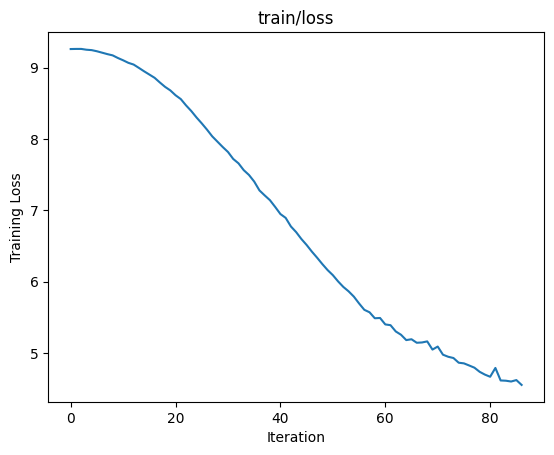

In [ ]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Prepare lists to store metrics
train_losses = []
val_losses = []
eval_iterations = []
iterations = []

print("--- Starting Training Loop ---")
t0 = time.time()

for iter_num in range(start_iter, training_args['max_iters']):
    # Update learning rate
    lr = compute_lr(
        iter_num,
        training_args['learning_rate'],
        training_args['min_lr'],
        training_args['warmup_steps'],
        training_args['lr_decay_steps']
    )
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Fetch batch and compute loss
    inputs, targets = get_batch(train_data, training_args['batch_size'], model_args['context_length'], device)
    logits = model(inputs)
    loss = loss_init(logits.view(-1, model_args['vocab_size']), targets.view(-1))

    # Backprop and optimization
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    gradient_cliping(model.parameters(), training_args['gradient_clip_val'])
    optimizer.step()

    # Record training loss
    train_losses.append(loss.item())
    iterations.append(iter_num)

    # Real-time logging
    if iter_num % 10 == 0:
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        print(f"Iter {iter_num}/{training_args['max_iters']}, Train Loss: {loss.item():.4f}, LR: {lr:.6f}, Time: {dt*1000:.2f}ms")

    # Evaluation step
    if iter_num > 0 and iter_num % training_args['eval_interval'] == 0:
        val_loss = evaluate()
        val_losses.append(val_loss)
        eval_iterations.append(iter_num)
        print(f"--- Eval at iter {iter_num}: Val Loss: {val_loss:.4f} ---")
        
        # Save checkpoint
        checkpoint_path = os.path.join(data_args['checkpoint_dir'], f"model_iter_{iter_num}.pt")
        save(model, optimizer, iter_num, checkpoint_path)

    # Plotting
    clear_output(wait=True)
    # Plot training loss
    plt.figure()
    plt.plot(iterations, train_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Training Loss')
    plt.title('train/loss')
    plt.show()

    # Plot validation loss if available
    if val_losses:
        plt.figure()
        plt.plot(eval_iterations, val_losses)
        plt.xlabel('Iteration')
        plt.ylabel('Validation Loss')
        plt.title('val/loss')
        plt.show()

    # Small pause to allow render
    time.sleep(0.01)

print("Training complete!")


In [ ]:
print("--- Training Finished! ---")
final_checkpoint_path = os.path.join(data_args['checkpoint_dir'], "model_final.pt")
save(model, optimizer, training_args['max_iters'], final_checkpoint_path)